<a href="https://colab.research.google.com/github/debbiedebdeb/gg/blob/master/ST2_moviesipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

영화 관객수 예측 모델 만들기 

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.compose import ColumnTransformer #특정 컬럼들만 변환할 때 사용
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [2]:
!sudo apt-get install -y fonts-nanum  
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family = 'NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# FILE 불러오기 및 확인

In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/LAB PYTHON /STUDYGROUP/data set/movies/movies_train.csv'
movies_test_path = '/content/drive/MyDrive/Colab Notebooks/LAB PYTHON /STUDYGROUP/data set/movies/movies_test.csv'
submission_path = '/content/drive/MyDrive/Colab Notebooks/LAB PYTHON /STUDYGROUP/data set/movies/submission.csv'

In [4]:
train = pd.read_csv(train_path)
test = pd.read_csv(movies_test_path)
submission = pd.read_csv(submission_path)

* 데이터 소개 : 2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터

```
* title : 영화의 제목
* distributor : 배급사
* genre : 장르
* release_time : 개봉일
* time : 상영시간(분)
* screening_rat : 상영등급
* director : 감독이름
* dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의   평균 관객수(단 관객수가 알려지지 않은 영화 제외)
* dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
* num_staff : 스텝수
* num_actor : 주연배우수
* box_off_num : 관객수
```

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


> 600개의 관측치, 12개의 columns . 
* null값 유무 : dir_prev_bfnum 

In [6]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


> time	dir_prev_bfnum	dir_prev_num	num_staff	num_actor	box_off_num 중 'dir_prev_bfnum', 'dir_prev_num', 'num_staff 컬럼의 분산이 크다는걸 알 수 있다 

In [7]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [8]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [9]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [10]:
# 변수형, 연속형 카테고리 숫자 확인
train.dtypes.value_counts()

object     6
int64      5
float64    1
dtype: int64

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


# 데이터 분석(EDA)

## 카테고리형 변수 분석 

 1   distributor    
 2   genre           
 3   release_time    
 5   screening_rat  
 6   director      

In [12]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [13]:
train.genre.value_counts() # 시각화

드라마       221
다큐멘터리      93
멜로/로맨스     78
코미디        53
공포         42
액션         28
느와르        27
애니메이션      21
미스터리       17
SF         13
뮤지컬         5
서스펜스        2
Name: genre, dtype: int64

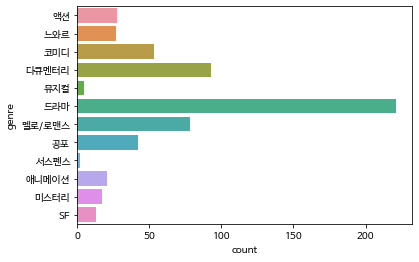

In [14]:
sns.countplot(y = 'genre', data = train)
plt.show()

In [15]:
train.screening_rat.value_counts()

청소년 관람불가    204
15세 관람가     202
12세 관람가     102
전체 관람가       92
Name: screening_rat, dtype: int64

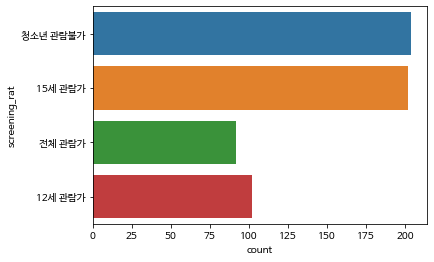

In [16]:
sns.countplot(y = 'screening_rat', data = train)
plt.show()

In [17]:
train['director'].value_counts()

홍상수           7
장률            4
신재호           4
우민호           4
노진수           4
             ..
권오광           1
한윤선           1
박찬경           1
New Pistol    1
백운학           1
Name: director, Length: 472, dtype: int64

In [18]:
train['distributor'].value_counts()

CJ 엔터테인먼트        54
롯데엔터테인먼트         52
(주)NEW           30
(주)마운틴픽쳐스        29
(주)쇼박스           26
                 ..
OAL(올)            1
(주)에이원 엔터테인먼트     1
(주)콘텐츠 윙          1
위더스필름             1
퍼스트런              1
Name: distributor, Length: 169, dtype: int64

In [19]:
# 관람객 수별 TOP 
train.sort_values('box_off_num', ascending = False ).head(10)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
372,국제시장,CJ 엔터테인먼트,드라마,2014-12-17,126,12세 관람가,윤제균,NaN,0,869,4,14262766
362,도둑들,(주)쇼박스,느와르,2012-07-25,135,15세 관람가,최동훈,2.564692e+06,3,462,10,12983841
530,7번방의 선물,(주)NEW,코미디,2013-01-23,127,15세 관람가,이환경,8.190495e+05,2,300,8,12811435
498,암살,(주)쇼박스,액션,2015-07-22,139,15세 관람가,최동훈,5.169479e+06,4,628,3,12706663
460,"광해, 왕이 된 남자",CJ 엔터테인먼트,드라마,2012-09-13,131,15세 관람가,추창민,1.552541e+06,2,402,3,12323595
122,변호인,(주)NEW,드라마,2013-12-18,127,15세 관람가,양우석,NaN,0,311,5,11374879
496,설국열차,CJ 엔터테인먼트,SF,2013-08-01,125,15세 관람가,봉준호,NaN,0,67,10,9350351
101,관상,(주)쇼박스,드라마,2013-09-11,139,15세 관람가,한재림,1.242778e+06,2,298,6,9135806
505,해적: 바다로 간 산적,롯데엔터테인먼트,SF,2014-08-06,130,12세 관람가,이석훈,1.843895e+06,3,868,2,8666208
476,수상한 그녀,CJ 엔터테인먼트,코미디,2014-01-22,124,15세 관람가,황동혁,2.781990e+06,2,437,5,8659725


## 연속형 변수의 시각화 

In [20]:
int_cat_list = ['time',	'dir_prev_bfnum',	'dir_prev_num',	'num_staff'	,'num_actor'	,'box_off_num']

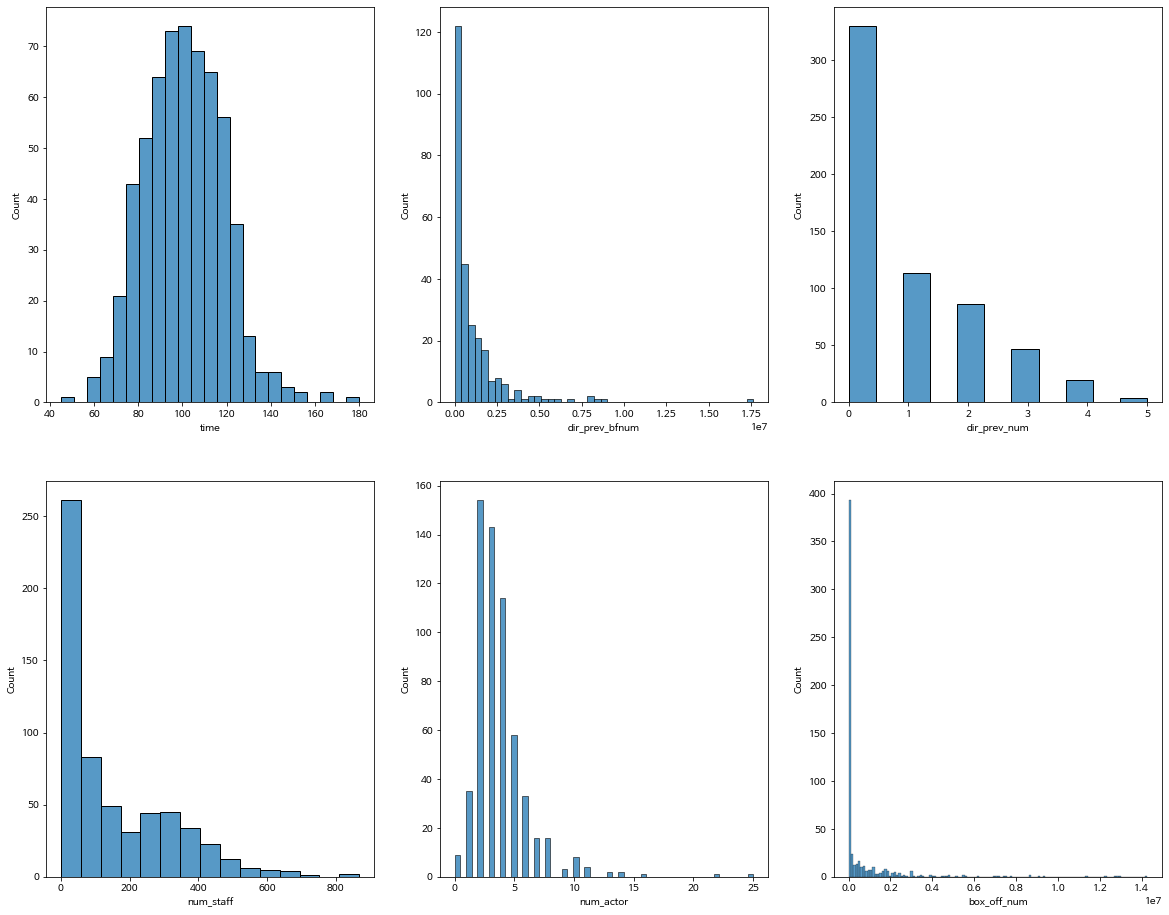

In [21]:
fig, ax = plt.subplots(2,3 , figsize = (20,16))
for idx, val in enumerate(int_cat_list) :
    i = idx // 3
    j = idx % 3
    sns.histplot(data= train, x = val, ax=ax[i,j])

plt.show()

In [22]:
#NaN 값 확인 
train[train['dir_prev_bfnum'].isnull()].dir_prev_num.value_counts()
# >> dir_prev_bfnum의 nan값은 dir_prev_num이 다 0 >> 그럼 전처리때 다 0으로 치환해야지

0    330
Name: dir_prev_num, dtype: int64

## 관객수와의 상관관계 확인

### 카테고리별 관객수 평균

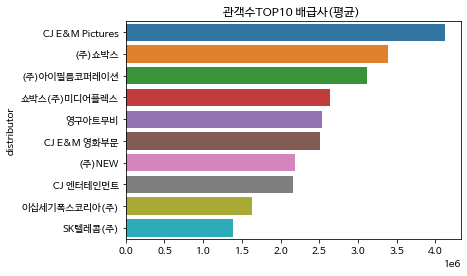

In [23]:
# 배급사별 관객수 평균 TOP 10 
top10_distributor = train.groupby('distributor')['box_off_num'].mean().sort_values(ascending = False).head(10)
sns.barplot(y = top10_distributor.index, x = top10_distributor.values)

plt.title('관객수TOP10 배급사(평균) ')
plt.show()

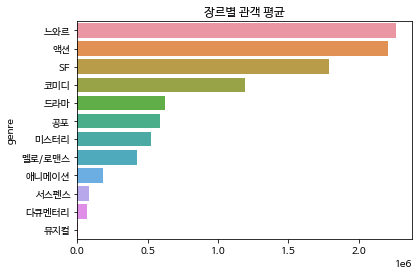

In [24]:
sort_by_genre = train.groupby('genre')['box_off_num'].mean().sort_values(ascending = False)
sns.barplot(y = sort_by_genre.index, x = sort_by_genre.values)

plt.title ('장르별 관객 평균')
plt.show()

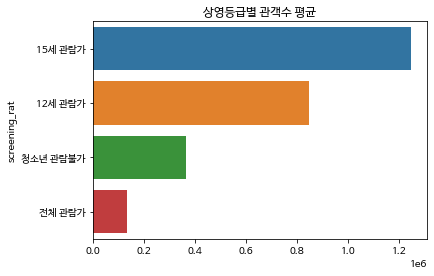

In [25]:
sort_by_sr = train.groupby('screening_rat')['box_off_num'].mean().sort_values(ascending = False)
sns.barplot(y = sort_by_sr.index, x = sort_by_sr.values)

plt.title ('상영등급별 관객수 평균')
plt.show()

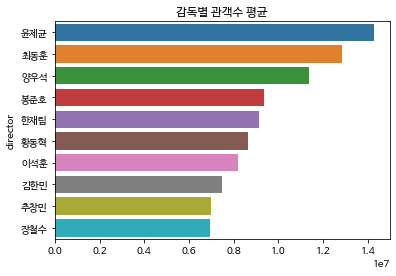

In [26]:
top10_by_director = train.groupby('director')['box_off_num'].mean().sort_values(ascending = False).head(10)
sns.barplot(y = top10_by_director.index, x = top10_by_director.values)

plt.title ('감독별 관객수 평균')
plt.show()

In [27]:
# 연도별, 월별, 분기별 차이 
# 1. data frame에서 release-time을 date타입으로 변환
train['release_time'] = pd.to_datetime(train.release_time)
train.info() # >>확인 완.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           600 non-null    object        
 1   distributor     600 non-null    object        
 2   genre           600 non-null    object        
 3   release_time    600 non-null    datetime64[ns]
 4   time            600 non-null    int64         
 5   screening_rat   600 non-null    object        
 6   director        600 non-null    object        
 7   dir_prev_bfnum  270 non-null    float64       
 8   dir_prev_num    600 non-null    int64         
 9   num_staff       600 non-null    int64         
 10  num_actor       600 non-null    int64         
 11  box_off_num     600 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 56.4+ KB


In [28]:
# 1. copy본으로 release_time을 인덱스화시켜서 시각화하기 
timecheck_df = train.copy()
time_idx = timecheck_df.set_index('release_time') # index에 넣어주기 

In [29]:
permonth = time_idx.resample('M')['box_off_num'].mean().sort_values(ascending = False) #month기준으로 평균내기 
peryear = time_idx.resample('Y')['box_off_num'].mean().sort_values(ascending = False) #month기준으로 평균내기 
perquarter = time_idx.resample('Q')['box_off_num'].mean().sort_values(ascending = False) #month기준으로 평균내기 

In [30]:
print(permonth.head(20))

release_time
2013-01-31    4.994967e+06
2013-12-31    2.207371e+06
2012-09-30    2.037369e+06
2012-07-31    2.029377e+06
2011-01-31    1.883352e+06
2011-05-31    1.882165e+06
2014-12-31    1.737643e+06
2010-08-31    1.670543e+06
2013-06-30    1.649990e+06
2013-08-31    1.645495e+06
2012-02-29    1.612600e+06
2012-12-31    1.533205e+06
2014-01-31    1.493329e+06
2015-07-31    1.361066e+06
2011-08-31    1.325143e+06
2010-12-31    1.119561e+06
2012-01-31    1.040174e+06
2015-11-30    1.039520e+06
2013-09-30    1.033184e+06
2010-06-30    9.995810e+05
Name: box_off_num, dtype: float64


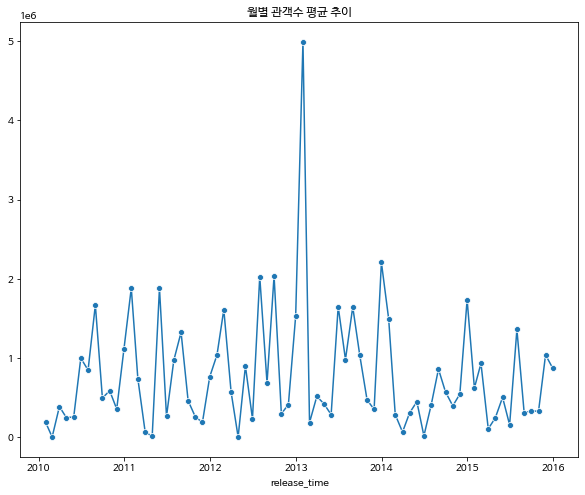

In [31]:
plt.figure(figsize = (10,8))
sns.lineplot(x = permonth.index, y = permonth.values, marker = 'o')
plt.title('월별 관객수 평균 추이')
plt.show()
# >>연초(1월), 방학(7~8월), 연말 (12월)에 많이 보는군

> Q. 월별기준으로 하고싶은데, 월(month)가 어떤 영향을 미치는지 정확히 어떻게 설명할 수 있을까 ? 

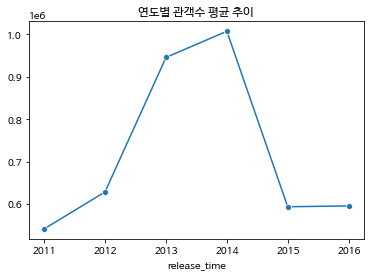

In [32]:
sns.lineplot(x = peryear.index, y = peryear.values, marker = 'o')
plt.title('연도별 관객수 평균 추이')
plt.show()

> 영화값 가격 인상, 좌석별 차등 요금 도입 등..이런부분이 있지만, 연도가 그렇게 상관이 있을것 같진 않다 

### 숫자형 변수와 관객수의 상관관계 

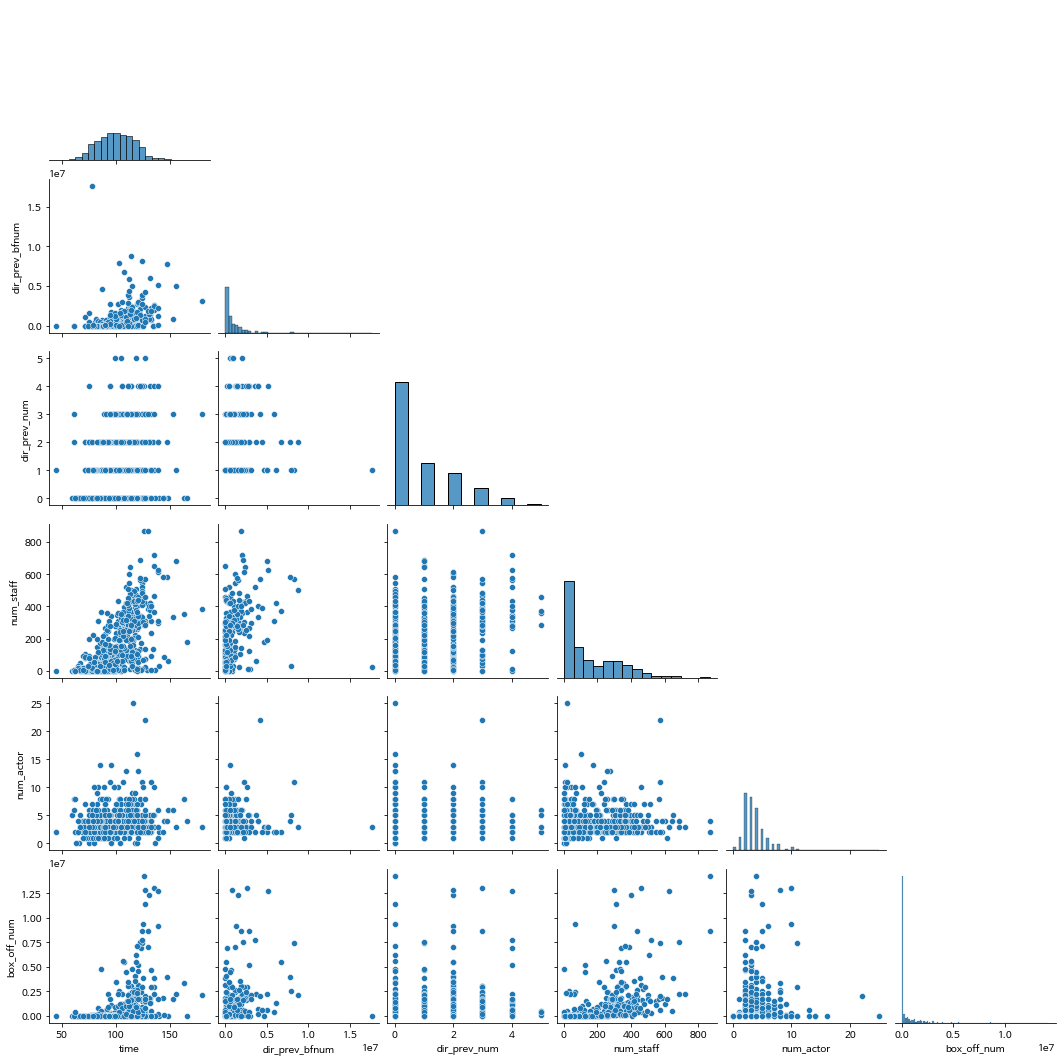

In [33]:
# 관계 없을듯..?
sns.pairplot(data = train, corner= True)
plt.show()

# 전처리

### 공통 전처리 

1. 기본 전처리
 * null 처리
 * column 삭제 - title , 감독 
 * release_time : year/ month 로 파생변수 처리 그리고 기존 date-time은 삭제 
 * get-dummies : genre / screening 
 * distributor : 상위 10개 빼곤 다 기타처리 (그냥 라벨링하려니까 안맞음) 

2. 바꿔볼 전처리 
 * 라벨링 or get dummies : distributor 
 * dir_prev_bf_num * dir_prev_num -> 파생변수 or 그대로 둘지 

* 전과 다른 점 : train / test 를 안합치고 전처리 

In [271]:
train = pd.read_csv(train_path)
test = pd.read_csv(movies_test_path)
submission = pd.read_csv(submission_path)

In [272]:
# NaN 값 처리 . 
train['dir_prev_bfnum'].fillna(0, inplace = True)
test['dir_prev_bfnum'].fillna(0, inplace = True)

# + inplace = True 할 경우, "0으로 채우고 저장"한다는 뜻. 

In [273]:
# colum 삭제 
train = train.drop(columns= ['title', 'director'])
test = test.drop(columns= ['title', 'director'])

In [274]:
# 상위 10개 배급사 제외하고 나머지 다 기타로 처리 ... 라벨링할때 문제 생겨서 
train.loc[~train.distributor.isin(top10_distributor.index),:'distributor'][:5]
# >> list에 포함하지 않는 데이터행들만 추출하고 싶다면 앞에 ~ 를 붙이면 된다. 

,distributor
0,롯데엔터테인먼트
5,롯데엔터테인먼트
6,백두대간
8,유니버설픽쳐스인터내셔널코리아
9,(주)두타연


In [275]:
train.loc[~train.distributor.isin(top10_distributor.index),:'distributor'] = '기타'

In [ ]:
def func(disributor) : 
    if distributor in top10_distributor : 
        return distributor 
    else : 
        return "기타"

train['distributor'] = train['distributor'].apply(lambda x : fun(x))

민희님 코드 

 distributor 배급사 상위 5개 제외 모두 기타로 처리
distributor_list = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))

In [276]:
train.distributor.value_counts()

기타                 477
CJ 엔터테인먼트           54
(주)NEW              30
(주)쇼박스              26
CJ E&M 영화부문          3
이십세기폭스코리아(주)         3
쇼박스(주)미디어플렉스         2
CJ E&M Pictures      2
영구아트무비               1
(주)아이필름코퍼레이션         1
SK텔레콤(주)             1
Name: distributor, dtype: int64

In [277]:
# test도 같이 진행 
test.loc[~test.distributor.isin(top10_distributor.index),:'distributor'] = '기타'

In [278]:
train.head()

,distributor,genre,release_time,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,기타,액션,2012-11-22,96,청소년 관람불가,0.00,0,91,2,23398
1,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,1161602.50,2,387,3,7072501
2,(주)쇼박스,액션,2013-06-05,123,15세 관람가,220775.25,4,343,4,6959083
3,(주)NEW,코미디,2012-07-12,101,전체 관람가,23894.00,2,20,6,217866
4,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,1.00,1,251,2,483387


In [279]:
#release_time : year/ month 로 파생변수 처리 그리고 기존 date-time은 삭제
train['year'] = train['release_time'].str[:4].astype('int')
train['month'] = train['release_time'].str[5:7].astype('int')

In [280]:
# test에도 적용 
test['year'] = test['release_time'].str[:4].astype('int')
test['month'] = test['release_time'].str[5:7].astype('int')

In [281]:
test.head(3)

,distributor,genre,release_time,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,month
0,기타,느와르,2010-01-07,125,청소년 관람불가,3.005290e+05,2,304,3,2010,1
1,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,3.427002e+05,4,275,3,2010,1
2,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,4.206611e+06,3,419,7,2010,1


In [282]:
train = train.drop(columns='release_time')
test = test.drop(columns='release_time')

In [283]:
#get-dummies : genre / screening
train = pd.get_dummies(train, columns= ['genre', 'screening_rat'])
test = pd.get_dummies(test, columns= ['genre', 'screening_rat'])

In [284]:
train.head()

,distributor,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,genre_SF,...,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,기타,96,0.00,0,91,2,23398,2012,11,0,...,0,0,0,0,1,0,0,0,0,1
1,(주)쇼박스,130,1161602.50,2,387,3,7072501,2015,11,0,...,0,0,0,0,0,0,0,0,0,1
2,(주)쇼박스,123,220775.25,4,343,4,6959083,2013,6,0,...,0,0,0,0,1,0,0,1,0,0
3,(주)NEW,101,23894.00,2,20,6,217866,2012,7,0,...,0,0,0,0,0,1,0,0,1,0
4,쇼박스(주)미디어플렉스,108,1.00,1,251,2,483387,2010,11,0,...,0,0,0,0,0,1,0,1,0,0


In [285]:
# time 구간화 
labels = [1.5,2.0,2.5]
bins = [40, 90, 120, 2016]

train['time'] = pd.cut(train.time, labels = labels, bins = bins, right=False )

In [286]:
test['time'] = pd.cut(test.time, labels = labels, bins  =bins , right = False )

In [287]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   distributor             243 non-null    object  
 1   time                    243 non-null    category
 2   dir_prev_bfnum          243 non-null    float64 
 3   dir_prev_num            243 non-null    int64   
 4   num_staff               243 non-null    int64   
 5   num_actor               243 non-null    int64   
 6   year                    243 non-null    int64   
 7   month                   243 non-null    int64   
 8   genre_SF                243 non-null    uint8   
 9   genre_공포                243 non-null    uint8   
 10  genre_느와르               243 non-null    uint8   
 11  genre_다큐멘터리             243 non-null    uint8   
 12  genre_드라마               243 non-null    uint8   
 13  genre_멜로/로맨스            243 non-null    uint8   
 14  genre_뮤지컬               24

* astype('int') : 온전산 숫자타입을 다른 숫자 타입으로 바꿀 때 이용 (float -> int)
* pd.to_numeric(df[' '])

* to_numeric의 error 인자를 coerce로 설정할 경우 :  숫자로 변경할 수 없는 문자를 nan으로 변경하여 반환한다함.

In [288]:
train['time'] = pd.to_numeric(train.time)
test['time'] = pd.to_numeric(test.time)

> 이후 전처리 1용, 2용으로 나눠서 저장하고 진행 고고

## 전처리 1 (라벨링만) 

In [289]:
train1 = train.copy()
test1 = test.copy()

1. 라벨링 distributor 

In [290]:
label = LabelEncoder()
train1['distributor'] = label.fit_transform(train1['distributor'])

In [291]:
train1.head(2)

,distributor,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,genre_SF,...,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,7,2.0,0.0,0,91,2,23398,2012,11,0,...,0,0,0,0,1,0,0,0,0,1
1,1,2.5,1161602.5,2,387,3,7072501,2015,11,0,...,0,0,0,0,0,0,0,0,0,1


In [292]:
test1['distributor'] = label.transform(test1['distributor'])

In [293]:
test1.head(2)

,distributor,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,month,genre_SF,genre_공포,...,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,7,2.5,300529.00,2,304,3,2010,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,2.0,342700.25,4,275,3,2010,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [294]:
test[test.time.isna()]

,distributor,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,month,genre_SF,genre_공포,...,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가


## 전처리2 

(time, distributor get dummies, dir_prev_bf_num * dir_prev_num -> 파생변수 or 그대로 둘지)

# modeling (LGBM,  RandomForest, XGB) 

In [295]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

In [296]:
rf = RandomForestRegressor()

In [297]:
lgb = lgb.LGBMRegressor() # 일단 기본으로 
xgb = xgb.XGBRegressor()

In [298]:
# train set에서 X, y 뽑아내기 
y = train1.pop('box_off_num').values.copy()
X = train1.values.copy()

In [299]:
# X, y shape check
X.shape, y.shape

((600, 24), (600,))

In [300]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [301]:
model_rf = Pipeline([('scale', StandardScaler()), ('reg', rf)]).fit(X_tr,y_tr)
model_lgb = Pipeline([('scale', StandardScaler()), ('reg', lgb)]).fit(X_tr,y_tr)
model_xgb = Pipeline([('scale', StandardScaler()), ('reg', xgb)]).fit(X_tr,y_tr)

[03:11:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [302]:
print('randomforest score : ' , model_rf.score(X_tr,y_tr))
print('lgb score : ' , model_lgb.score(X_tr,y_tr))
print('xgb score : ' , model_xgb.score(X_tr,y_tr))

randomforest score :  0.9073339698762394
lgb score :  0.7813253941541449
xgb score :  0.8910519185603738


In [303]:
print('randomforest score : ' , model_rf.score(X_te,y_te))
print('lgb score : ' , model_lgb.score(X_te,y_te))
print('xgb score : ' , model_xgb.score(X_te,y_te))

randomforest score :  0.415266442017618
lgb score :  0.4413595933717587
xgb score :  0.44530557129803905


..? 뭐지 이 쓰레기는.. 

In [304]:
# cv로 해보기 
cv = cross_validate(estimator = model_rf, X= X, y = y, cv=5, n_jobs=-1, return_train_score = True)

In [305]:
print(np.mean(cv['train_score']))
print(np.mean(cv['test_score']))

0.9060735440753934
0.36261278484304593


In [306]:
# 위 과정을 한번에 처리할 수 있는... 함수 만들기 

def pipe_model_cv_score(models, X, y) : 
    for model in models : 
        pipe = Pipeline([('scale', StandardScaler()), ('reg', model)])
        cv = cross_validate(estimator = pipe, X= X, y = y, cv=5, n_jobs=-1, return_train_score = True)
        tr = np.mean(cv['train_score'])
        te = np.mean(cv['test_score'])
        
        print(model, 'train score : ', tr, 'test score', te)

In [307]:
models = [rf, lgb, xgb]

In [308]:
pipe_model_cv_score(models, X, y)

RandomForestRegressor() train score :  0.906258468196192 test score 0.3649367340189795
LGBMRegressor() train score :  0.7998570051568794 test score 0.3300866912958683
XGBRegressor() train score :  0.8818507022219253 test score 0.3311071986158671


## model tuning 

In [309]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid= params, n_jobs=-1, return_train_score = True)
    grid_model.fit(X,y)

    print('{0}5 CV시 최고 평균 : {1}, 최고 parameter : {2}'.format(model.__class__.__name__,grid_model.best_score_, grid_model.best_params_ ))

In [310]:
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
# LGBM 
lgb_params = {'learning_rate' : [0.005,0.01 ],  }
xgb_params = {'colsample_bytree' : [0.1,0.5], 'subsample' : [0.4,0.6,0.8] }
rf_params = {'max_depth' : [5,7,9,11], 'min_samples_split' : np.arange(1.0,2.0,0.3)}
lgb = LGBMRegressor( n_estimators = 500, n_jobs=-1, boosting_type = 'dart', num_leaves = 15)
xgb = XGBRegressor(n_estimators =  500, booster = 'dart', n_jobs = -1, learning_rate = 0.05)
rf = RandomForestRegressor(n_estimators =  300, n_jobs = -1)

In [311]:
rf_params = {'max_depth' : [12,13,14], 'min_samples_split' : np.arange(0.06,0.09,0.01)}
print_best_params(rf, rf_params)
# >> rf_params 로 채택 

RandomForestRegressor5 CV시 최고 평균 : 0.4244824553642341, 최고 parameter : {'max_depth': 13, 'min_samples_split': 0.06999999999999999}


In [312]:
# 파라미터로 저장 
best_rf = RandomForestRegressor(n_estimators =  300, n_jobs = -1, max_depth = 13, min_samples_split= 0.08)
# >  grid_model이 함수 안에 있는데 grid_model.best_estimator을 어떻게 써야하지? 궁금

In [313]:
print_best_params(lgb, lgb_params)

LGBMRegressor5 CV시 최고 평균 : 0.3666897873542853, 최고 parameter : {'learning_rate': 0.01}


In [314]:
print_best_params(xgb, xgb_params)

[03:12:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor5 CV시 최고 평균 : 0.2938636333881024, 최고 parameter : {'colsample_bytree': 0.1, 'subsample': 0.4}


In [315]:
best_rf.fit(X, y)

RandomForestRegressor(max_depth=13, min_samples_split=0.08, n_estimators=300,
                      n_jobs=-1)

In [ ]:
 best_rf.predict(test1)

In [317]:
submission['box_off_num']  = best_rf.predict(test1)
submission.head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,title,box_off_num
0,용서는 없다,2.254841e+06
1,아빠가 여자를 좋아해,1.348274e+06
2,하모니,1.741988e+06
3,의형제,1.678134e+06
4,평행 이론,1.493564e+06


In [338]:
import pandas as pd

In [340]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/LAB PYTHON /STUDYGROUP/data set/movies/result1.csv', index = False)

결과메모 
 * LGBM :
    * n_estimators = 500, (1000과 비교했을때 500이 나음) 
    * learning_rate : 0.01 ( 0.05일때보다 더 나은 결과) 
    * num_leaves :15  (23일때보다 더 나은 결과)
    * boosting_type : dart 
 * XGB : 
    * n_estimators = 500
    * learning_rate = 0.05
    * cosample_bytree : 0.1일때
    * subsample : 0.4 

 * RF : 
  * RandomForestRegressor5 CV시 최고 평균 : 0.40373278672182067, 최고 parameter : {'max_depth': 20, 'min_samples_split': 0.05}
  * RandomForestRegressor5 CV시 최고 평균 : 0.42203254186637995, 최고 parameter : {'max_depth': 13, 'min_samples_split': 0.07999999999999999}

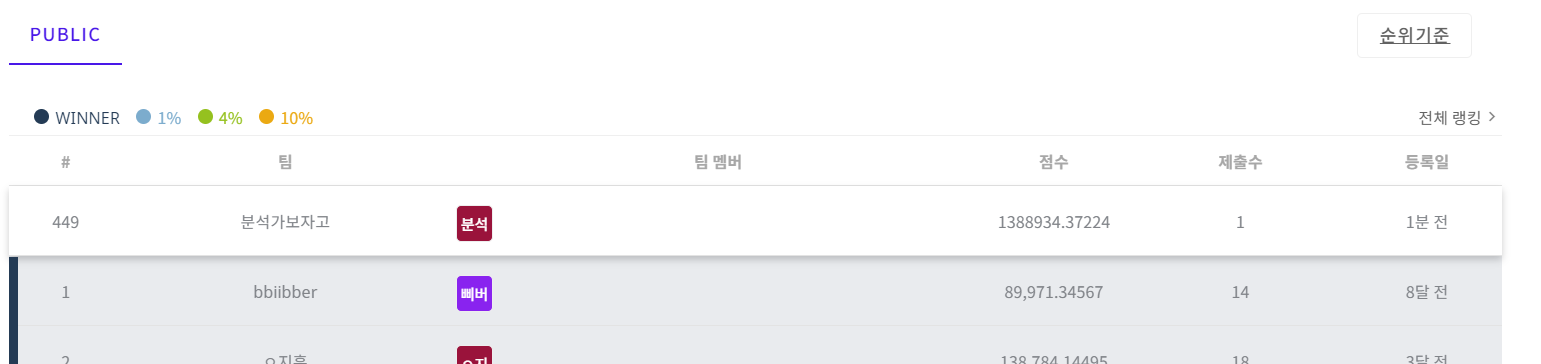

## 기본값으로 진행 

In [318]:
# 일단 기본값으로 진행 
knn = KNeighborsRegressor(n_jobs = -1)
rf = RandomForestRegressor(n_estimators = 200, n_jobs = -1)
lin = LinearRegression(n_jobs = -1)
ridge = Ridge() 
lasso = Lasso()
ela = ElasticNet()

In [319]:
model_list = [knn, rf, lin, ridge, lasso, ela]

In [320]:
# r2 score 
def rmse_result_cv(esti, X, y) : 
    pipe = Pipeline([ ('scale' , StandardScaler()),
                     ('esti', esti )])
    cv = cross_validate(estimator = pipe, X = X, y = y, cv=5, n_jobs = -1, return_train_score = True, ) 
    tr_score = np.mean(cv['train_score'])
    te_score = np.mean(cv['test_score'])
    
    return tr_score, te_score

In [321]:
# 빈 리스트 생성 
tr_result = []
te_result = []

In [322]:
rmse_result_cv(knn,X,y)

(0.4640857278191712, 0.16560447989612137)

In [323]:
# 각 model별 train test score을 list에 넣기 
for m in model_list : 
    tr_result.append(rmse_result_cv(m, X, y)[0])
    te_result.append(rmse_result_cv(m, X, y)[1])

In [324]:
#result를 df로 만들어서 비교하기
result_df = pd.DataFrame({'model' : model_list, 
                          'train sc' : tr_result, 
                          'test sc' : te_result})

In [325]:
result_df # 하이퍼파라미터 튜닝 전 결과 ...쑬액이~

,model,train sc,test sc
0,KNeighborsRegressor(n_jobs=-1),0.464086,0.165604
1,"RandomForestRegressor(n_estimators=200, n_jobs...",0.910097,0.389700
2,LinearRegression(n_jobs=-1),0.398464,0.314095
3,Ridge(),0.403932,0.318186
4,Lasso(),0.403933,0.317974
5,ElasticNet(),0.384128,0.327374


In [326]:
# 위 과정을 한번에 하는 함수 만들기 

def model_result_df(arr, X, y) :
    tr_result = []
    te_result = []
    for m in arr : 
        tr_result.append(rmse_result_cv(m, X, y)[0])
        te_result.append(rmse_result_cv(m, X, y)[1])
    result_df = pd.DataFrame({'model' : model_list, 
                          'train sc' : tr_result, 
                          'test sc' : te_result})
    return result_df

In [327]:
model_result_df(model_list, X, y)

,model,train sc,test sc
0,KNeighborsRegressor(n_jobs=-1),0.464086,0.165604
1,"RandomForestRegressor(n_estimators=200, n_jobs...",0.909634,0.384926
2,LinearRegression(n_jobs=-1),0.398464,0.314095
3,Ridge(),0.403932,0.318186
4,Lasso(),0.403933,0.317974
5,ElasticNet(),0.384128,0.327374


## 하이퍼파라미터 찾기

In [328]:
# 회귀 계수값 상위 5개, 하위 5개 피처명과 그 회귀 계수 값을 가지는 판다스 시리즈 객체를 반환하는 함수 
def get_topbottom_coef(model,X,y, n=5) :
    model = model.fit(X, y)
    coef = pd.Series(model.coef_, index = train.columns)
    # 상위10개, 하위 10개의 회귀 계수 추출
    coef_high = coef.sort_values(ascending = False).head(n)
    coef_low = coef.sort_values(ascending = False).tail(n)
    return coef_high, coef_low

In [329]:
def visualize_coef(models, X, y) : 
    fig, ax = plt.subplots(1,len(models), figsize = (30,20))
    plt.tight_layout()
    #입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀계수 시각화
    for i, m in enumerate(models) : 
        #상위 하위 5개 회귀 계수 구하고 판다스 concat으로 결합
        coef_high, coef_low = get_topbottom_coef(m, X, y)
        coef_concet = pd.concat([coef_high, coef_low])

        # ax subplots에 barchart로 표현. 
        ax[i].set_title(m.__class__.__name__ + '  coef', size = 25)
        ax[i].tick_params(axis = 'y', direction = 'in', pad = -120)
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()) : 
            label.set_fontsize(22)
        sns.barplot(x = coef_concet.values, y = coef_concet.index, ax = ax[i])
        plt.show

In [353]:
model_list = [ ridge, lasso, xgb]

ValueError: ignored

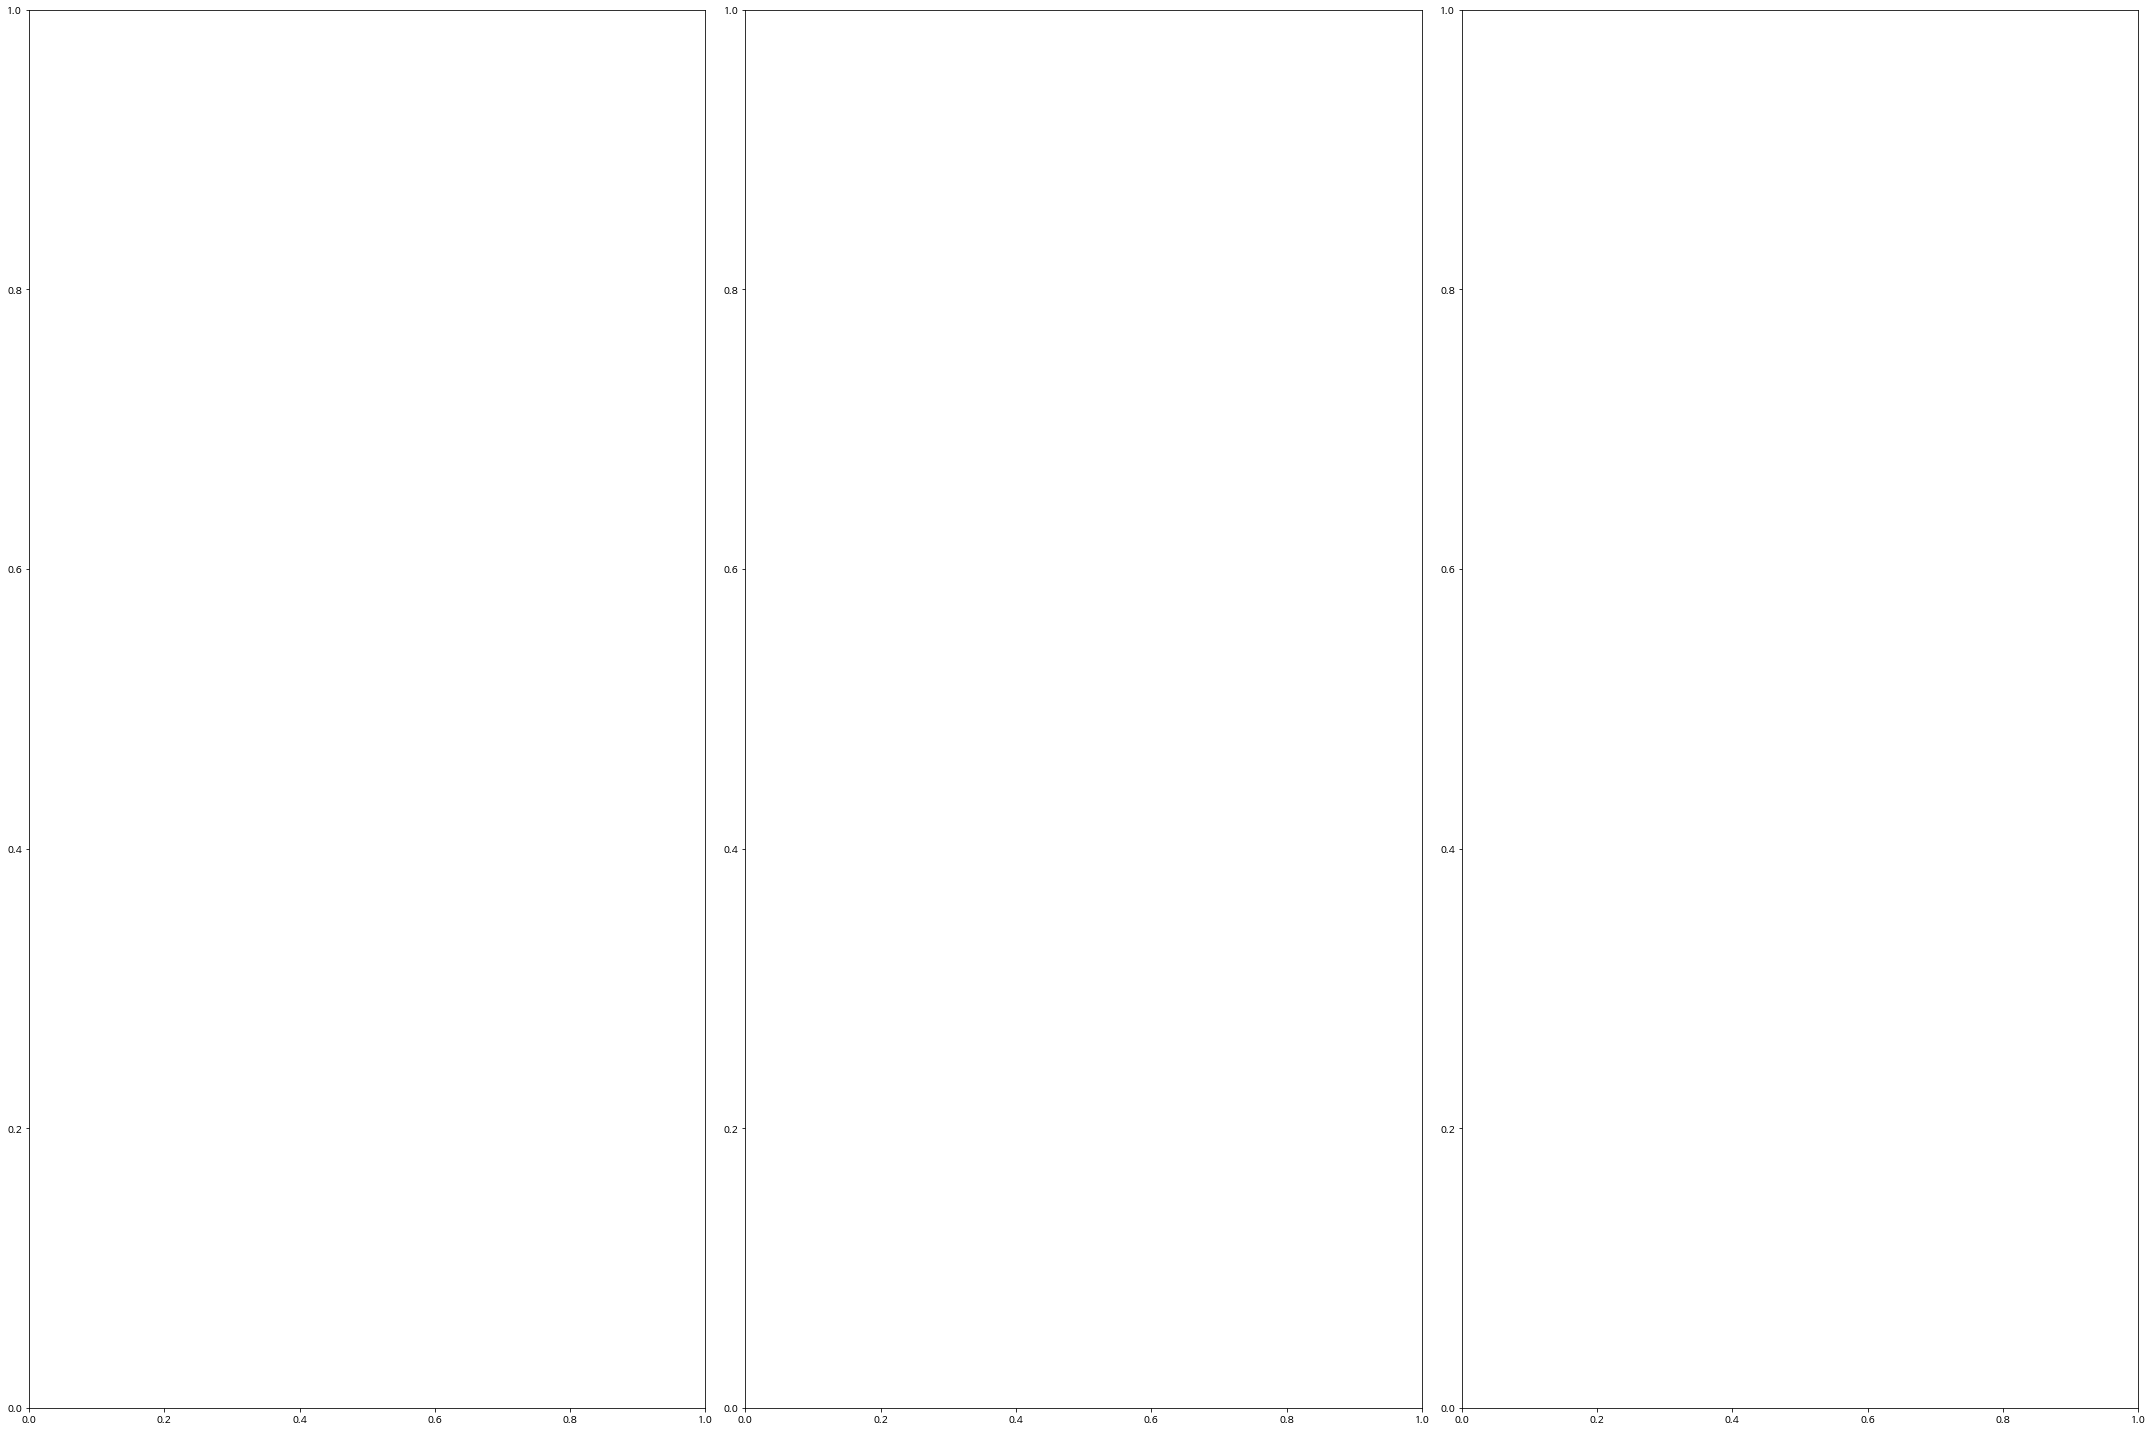

In [354]:
visualize_coef(model_list, X, y)

### randomForestRegressor 

In [ ]:
params = [{'max_depth' : np.arange(1,9,2),
           'min_samples_split' : np.arange(0.01,0.12, 0.02)}]

In [ ]:
grid = GridSearchCV(estimator = rf, param_grid = params, n_jobs = -1, return_train_score=True)

In [ ]:
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
best_rf = grid.best_estimator_
best_rf

### Ridge, Lasso 

In [ ]:
params = [{'alpha' : np.arange(19,30)}]

In [ ]:
# Ridge
grid = GridSearchCV(estimator = ridge, param_grid = params, n_jobs = -1, return_train_score=True)

In [ ]:
grid.fit(X,y)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
#Lasso 
params = [{'alpha' : np.arange(100,120)}]
grid = GridSearchCV(estimator = lasso, param_grid = params, n_jobs = -1, return_train_score=True)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
# ElasticNet
ela = ElasticNet(max_iter = 100000)
params = [{'alpha' : np.arange(-3,10)}]
grid = GridSearchCV(estimator = ela, param_grid = params, n_jobs = -1, return_train_score=True)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)

# 공부했던 사이트 

* XGBOOST parameter
    * https://dining-developer.tistory.com/4
    * https://velog.io/@dbj2000/ML